In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root
from scipy.special import erfc
from scipy.interpolate import InterpolatedUnivariateSpline as Spline
from scipy.integrate import simps

/home/IPP-HGW/patricks/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
R1 = 0.2
R2 = 8
r = np.linspace(R1, R2, 500)
l = len(r)
dr = (np.max(r)-np.min(r))/(l-1)

In [3]:
@njit
def dF_dr(r, dr, lr, n0):
    df_dr = np.zeros((lr, lr, lr))
    v_para = np.linspace(0, 10, lr)
    v_perp = np.linspace(0, 10, lr)

    for i in range(lr-1):
        dn_dr = (r[i]-dr/2)*(n0[i+1]-n0[i])/dr
        n = (n0[i+1]+n0[i])/2
        for j in range(lr):
            for k in range(lr):
                df_dr[i, j, k] = np.exp(-v_para[j]**2-v_perp[k]**2)*(dn_dr - n*(v_para[j]**2+v_perp[k]**2/2))
    return(df_dr)

In [4]:
@njit(parallel=True)
def InF(v_max, lr, a):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf = np.zeros(len(a))

    for i in prange(len(a)):
        bra = a[i]*(v_para[0]**2+v_perp[0]/2)
        f = np.exp(-v_para[0]**2/2-v_perp[0]/2)/(1+bra)
        inf_dperp0 = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = a[i]*(v_para[0]**2+v_perp[l]/2)
            f0 = f
            f = np.exp(-v_para[0]**2/2-v_perp[l]/2)/(1+bra)
            inf_dperp0 = inf_dperp0 + dperp*(f+f0)/2
        for j in range(1, lr):
            bra = a[i]*(v_para[j]**2+v_perp[0]/2)
            f = np.exp(-v_para[j]**2/2-v_perp[0]/2)/(1+bra)
            inf_dperp = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = a[i]*(v_para[j]**2+v_perp[k]/2)
                f0 = f
                f = np.exp(-v_para[j]**2/2-v_perp[k]/2)/(1+bra)
                inf_dperp = inf_dperp + dperp*(f+f0)/2
            inf[i] = inf[i] + (v_para[j]-v_para[j-1])*(inf_dperp+inf_dperp0)/2
            inf_dperp0 = inf_dperp
            
    return inf

In [5]:
@njit(parallel=True)
def InF(v_max, lr, a):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(a))
    inf_i = np.zeros(len(a))
    a_r = np.real(a)
    a_i = np.imag(a)

    for i in prange(len(a)):
        bra = v_para[0]**2+v_perp[0]/2
        den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
        exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
        f_r = (1+a_r[i]*bra)*exp/den
        f_i = -a_i[i]*bra*exp/den
        inf_dperp0_r = 0
        inf_dperp0_i = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = v_para[0]**2+v_perp[l]/2
            den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
            exp = np.exp(-v_para[0]**2/2-v_perp[l]/2)
            f0_r = f_r
            f0_i = f_i
            f_r = (1+a_r[i]*bra)*exp/den
            f_i = -a_i[i]*bra*exp/den
            inf_dperp0_r = inf_dperp0_r + dperp*(f_r+f0_r)/2
            inf_dperp0_i = inf_dperp0_i + dperp*(f_i+f0_i)/2
        for j in range(1, lr):
            bra = v_para[j]**2+v_perp[0]/2
            den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
            exp = np.exp(-v_para[j]**2/2-v_perp[0]/2)
            f_r = (1+a_r[i]*bra)*exp/den
            f_i = -a_i[i]*bra*exp/den
            inf_dperp_r = 0
            inf_dperp_i = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = v_para[j]**2+v_perp[k]/2
                den = (1+a_r[i]*bra)**2 + (a_i[i]*bra)**2
                exp = np.exp(-v_para[j]**2/2-v_perp[k]/2)
                f0_r = f_r
                f0_i = f_i
                f_r = (1+a_r[i]*bra)*exp/den
                f_i = -a_i[i]*bra*exp/den
                inf_dperp_r = inf_dperp_r + dperp*(f_r+f0_r)/2
                inf_dperp_i = inf_dperp_i + dperp*(f_i+f0_i)/2
            inf_r[i] = inf_r[i] + (v_para[j]-v_para[j-1])*(inf_dperp_r+inf_dperp0_r)/2
            inf_i[i] = inf_i[i] + (v_para[j]-v_para[j-1])*(inf_dperp_i+inf_dperp0_i)/2
            inf_dperp0_r = inf_dperp_r
            inf_dperp0_i = inf_dperp_i
            
    return inf_r, inf_i

In [168]:
@njit(parallel=True)
def InF_ani(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(n0))
    inf_i = np.zeros(len(n0))

    for i in prange(len(a)):
        bra = v_para[0]**2+v_perp[0]/2
        den_i = omega[1]
        den_r = omega[0] - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[0]**2
        exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
        f_r = (dn0[i]+n0[i]*bra)*den_r*exp/(den_r**2+den_i**2)
        f_i = -(dn0[i]+n0[i]*bra)*den_i*exp/(den_r**2+den_i**2)
        inf_dperp0_r = 0
        inf_dperp0_i = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = v_para[0]**2+v_perp[l]/2
            den_i = omega[1]
            den_r = omega[0] - in0[i] - kl_perp*v_perp[l]/2 - kl_para*v_para[0]**2
            exp = np.exp(-v_para[0]**2/2-v_perp[l]/2)
            f0_r = f_r
            f0_i = f_i
            f_r = (dn0[i]+n0[i]*bra)*den_r*exp/(den_r**2+den_i**2)
            f_i = -(dn0[i]+n0[i]*bra)*den_i*exp/(den_r**2+den_i**2)
            inf_dperp0_r = inf_dperp0_r + dperp*(f_r+f0_r)/2
            inf_dperp0_i = inf_dperp0_i + dperp*(f_i+f0_i)/2
        for j in range(1, lr):
            bra = v_para[j]**2+v_perp[0]/2
            den_i = omega[1]
            den_r = omega[0] - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[j]**2
            exp = np.exp(-v_para[j]**2/2-v_perp[0]/2)
            f_r = (dn0[i]+n0[i]*bra)*den_r*exp/(den_r**2+den_i**2)
            f_i = -(dn0[i]+n0[i]*bra)*den_i*exp/(den_r**2+den_i**2)
            inf_dperp_r = 0
            inf_dperp_i = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = v_para[j]**2+v_perp[k]/2
                den_i = omega[1]
                den_r = omega[0] - in0[i] - kl_perp*v_perp[k]/2 - kl_para*v_para[j]**2
                exp = np.exp(-v_para[j]**2/2-v_perp[k]/2)
                f0_r = f_r
                f0_i = f_i
                f_r = (dn0[i]+n0[i]*bra)*den_r*exp/(den_r**2+den_i**2)
                f_i = -(dn0[i]+n0[i]*bra)*den_i*exp/(den_r**2+den_i**2)
                inf_dperp_r = inf_dperp_r + dperp*(f_r+f0_r)/2
                inf_dperp_i = inf_dperp_i + dperp*(f_i+f0_i)/2
            inf_r[i] = inf_r[i] + (v_para[j]-v_para[j-1])*(inf_dperp_r+inf_dperp0_r)/2
            inf_i[i] = inf_i[i] + (v_para[j]-v_para[j-1])*(inf_dperp_i+inf_dperp0_i)/2
            inf_dperp0_r = inf_dperp_r
            inf_dperp0_i = inf_dperp_i
            
    return inf_r, inf_i

In [6]:
@njit(parallel = True)
def Int_ani(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(n0))
    inf_i = np.zeros(len(n0))
    om = omega[0] + 1j*omega[1]

    for i in prange(len(n0)):
        if n0[i] == 0 and dn0[i] == 0:
            continue
        bra = v_para[0]**2+v_perp[0]/2
        den = om - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[0]**2
        exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
        f = exp/den*(dn0[i] + n0[i]*bra)
        inf_dperp0 = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = v_para[0]**2+v_perp[l]/2
            den = om - in0[i] - kl_perp*v_perp[l]/2 - kl_para*v_para[0]**2
            exp = np.exp(-v_para[0]**2/2-v_perp[l]/2)
            f0 = f
            f = exp/den*(dn0[i] + n0[i]*bra)
            inf_dperp0 = inf_dperp0 + dperp*(f+f0)/2
        for j in range(1, lr):
            bra = v_para[j]**2+v_perp[0]/2
            den = om - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[j]**2
            exp = np.exp(-v_para[j]**2/2-v_perp[0]/2)
            f = exp/den*(dn0[i] + n0[i]*bra)
            inf_dperp = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = v_para[j]**2+v_perp[k]/2
                den = om - in0[i] - kl_perp*v_perp[k]/2 - kl_para*v_para[j]**2
                exp = np.exp(-v_para[j]**2/2-v_perp[k]/2)
                f0 = f
                f = exp/den*(dn0[i] + n0[i]*bra)
                inf_dperp = inf_dperp + dperp*(f+f0)/2
            inf_r[i] = inf_r[i] + np.real((v_para[j]-v_para[j-1])*(inf_dperp+inf_dperp0)/2)
            inf_i[i] = inf_i[i] + np.imag((v_para[j]-v_para[j-1])*(inf_dperp+inf_dperp0)/2)
            inf_dperp0 = inf_dperp
            
    return inf_r, inf_i

In [51]:
@njit(parallel = True)
def Int_ani(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(n0))
    inf_i = np.zeros(len(n0))

    for i in prange(len(n0)):
        if n0[i] == 0 and dn0[i] == 0:
            continue
        bra = v_para[0]**2+v_perp[0]/2
        den_r = omega[0] - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[0]
        den_i = omega[1]
        exp = np.exp(-v_para[0]**2/2-v_perp[0]/2)
        f_r = den_r*(dn0[i] + n0[i]*bra)*exp/(den_r**2 + den_i**2)
        f_i = -den_i*(dn0[i] + n0[i]*bra)*exp/(den_r**2 + den_i**2)
        inf_dperp0_r = 0
        inf_dperp0_i = 0
        for l in range(1, lr):
            dperp = (v_perp[l]-v_perp[l-1])
            bra = v_para[0]**2+v_perp[l]/2
            den_r = omega[0] - in0[i] - kl_perp*v_perp[l]/2 - kl_para*v_para[0]
            den_i = omega[1]
            exp = np.exp(-v_para[0]**2/2-v_perp[l]/2)
            f0_r = f_r
            f_r = den_r*(dn0[i] + n0[i]*bra)*exp/(den_r**2 + den_i**2)
            f0_i = f_i
            f_i = -den_i*(dn0[i] + n0[i]*bra)*exp/(den_r**2 + den_i**2)
            inf_dperp0_r = inf_dperp0_r + dperp*(f_r+f0_r)/2
            inf_dperp0_i = inf_dperp0_i + dperp*(f_i+f0_i)/2
        for j in range(1, lr):
            bra = v_para[j]**2+v_perp[0]/2
            den_r = omega[0] - in0[i] - kl_perp*v_perp[0]/2 - kl_para*v_para[j]
            den_i = omega[1]
            exp = np.exp(-v_para[j]**2/2-v_perp[0]/2)
            f_r = den_r*(dn0[i] + n0[i]*bra)*exp/(den_r**2 + den_i**2)
            f_i = -den_i*(dn0[i] + n0[i]*bra)*exp/(den_r**2 + den_i**2)
            inf_dperp_r = 0
            inf_dperp_i = 0
            for k in range(1, lr):
                dperp = (v_perp[k]-v_perp[k-1])
                bra = v_para[j]**2+v_perp[k]/2
                den_r = omega[0] - in0[i] - kl_perp*v_perp[k]/2 - kl_para*v_para[j]
                den_i = omega[1]
                exp = np.exp(-v_para[j]**2/2-v_perp[k]/2)
                f0_r = f_r
                f0_i = f_i
                f_r = den_r*(dn0[i] + n0[i]*bra)*exp/(den_r**2 + den_i**2)
                f_i = -den_i*(dn0[i] + n0[i]*bra)*exp/(den_r**2 + den_i**2)
                inf_dperp_r = inf_dperp_r + dperp*(f_r+f0_r)/2
                inf_dperp_i = inf_dperp_i + dperp*(f_i+f0_i)/2
            inf_r[i] = inf_r[i] + (v_para[j]-v_para[j-1])*(inf_dperp_r+inf_dperp0_r)/2
            inf_i[i] = inf_i[i] + (v_para[j]-v_para[j-1])*(inf_dperp_i+inf_dperp0_i)/2
            inf_dperp0_r = inf_dperp_r
            inf_dperp0_i = inf_dperp_i
            
    return inf_r, inf_i

In [7]:
@njit(parallel = True)
def Int_simps(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(n0))
    inf_i = np.zeros(len(n0))
    diag_i = np.zeros(len(n0))
    diag_r = np.zeros(len(n0))
    dv_perp = v_perp[1]
    dv_para = v_para[1]
    om = omega[0] + 1j*omega[1]

    for i in range(len(n0)):
        if n0[i] == 0 and dn0[i] == 0:
            continue
        for j in range(len(v_perp)):
            bra = v_para[j]**2+v_perp/2
            den = om - in0[i] - kl_perp*v_perp/2 - kl_para*v_para[i]**2
            exp = np.exp(-v_para[j]**2/2-v_perp/2)
            f = exp/den*(dn0[i] + n0[i]*bra)
            f_r = np.real(f)
            f_i = np.imag(f)
            inf_r[j] = dv_perp*(2*f_r[0] + f_r[1])/3
            inf_i[j] = dv_perp*(2*f_i[0] + f_i[1])/3
            for k in range(1, len(f)-1):
                inf_r[j] = inf_r[j] + dv_perp*(f_r[k-1] + 4*f_r[k] + f_r[k+1])/6
                inf_i[j] = inf_i[j] + dv_perp*(f_i[k-1] + 4*f_i[k] + f_i[k+1])/6
            if j >= 2:
                diag_r[i] = diag_r[i] + dv_para*(inf_r[j-2] + 4*inf_r[j-1] + inf_r[j])/6
                diag_i[i] = diag_i[i] + dv_para*(inf_i[j-2] + 4*inf_i[j-1] + inf_i[j])/6
        diag_r[i] = diag_r[i] + dv_para*(inf_r[0] + 2*inf_r[1])/3
        diag_i[i] = diag_i[i] + dv_para*(inf_i[0] + 2*inf_i[1])/3
            
    return diag_r, diag_i

In [8]:
@njit(parallel = True)
def Int_simps(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf = np.zeros(len(v_para),dtype=np.complex_)
    diag = np.zeros(len(n0),dtype=np.complex_)
    dv_perp = 2*v_perp[1]
    dv_para = 2*v_para[1]
    om = omega[0] + 1j*omega[1]

    for i in prange(len(n0)):
        if n0[i] == 0 and dn0[i] == 0:
            continue
        for j in range(lr):
            bra = v_para[j]**2+v_perp/2
            den = om - in0[i] - kl_perp*v_perp/2 - kl_para*v_para[j]**2
            exp = np.exp(-v_para[j]**2/2-v_perp/2)
            f = exp/den*(dn0[i] + n0[i]*bra)
            inf[j] = dv_perp*(2*f[0] + f[1])/3
            for k in range(1, lr//2-1):
                k2 = int(2*k)
                inf[j] = inf[j] + dv_perp*(f[k2-1] + 4*f[k2] + f[k2+1])/6
            if j%2 == 0 and j != 0:
                diag[i] = diag[i] + dv_para*(inf[j-2] + 4*inf[j-1] + inf[j])/6
        diag[i] = diag[i] + dv_para*(inf[0] + 2*inf[1])/3
            
    return np.real(diag), np.imag(diag)

In [103]:
@njit#(parallel = True)
def Int_simps(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(v_para))
    inf_i = np.zeros(len(v_para))
    diag_r = np.zeros(len(n0))
    diag_i = np.zeros(len(n0))
    dv_perp = 2*v_perp[1]
    dv_para = 2*v_para[1]

    for i in range(len(n0)):
        #if n0[i] == 0 and dn0[i] == 0:
        #    continue
        for j in range(lr):
            bra = v_para[j]**2+v_perp/2
            den_i = omega[1]
            den_r = omega[0] - in0[i] - kl_perp*v_perp/2 - kl_para*v_para[j]**2
            exp = np.exp(-v_para[j]**2/2-v_perp/2)
            f = exp*(dn0[i] + n0[i]*bra)/(den_i**2+den_r**2)
            dv_perp = 2*v_perp[1]
            inf_i[j] = -dv_perp*(2*den_i*f[0] + den_i*f[1])/3
            inf_r[j] = dv_perp*(2*den_r[0]*f[0] + den_r[1]*f[1])/3
            for k in range(1, lr//2-1):
                k2 = int(2*k)
                dv_perp = v_perp[k2+1]-v_perp[k2-1]
                inf_i[j] = inf_i[j] - dv_perp*(den_i*f[k2-1] + 4*den_i*f[k2] + den_i*f[k2+1])/6
                inf_r[j] = inf_r[j] + dv_perp*(den_r[k2-1]*f[k2-1] + 4*den_r[k2]*f[k2] + den_r[k2+1]*f[k2+1])/6
            if j%2 == 0 and j != 0:
                dv_para = v_para[j]-v_para[j-2]
                diag_i[i] = diag_i[i] + dv_para*(inf_i[j-2] + 4*inf_i[j-1] + inf_i[j])/6
                diag_r[i] = diag_r[i] + dv_para*(inf_r[j-2] + 4*inf_r[j-1] + inf_r[j])/6
        diag_i[i] = diag_i[i] + dv_para*(inf_i[0] + 2*inf_i[1])/3
        diag_r[i] = diag_r[i] + dv_para*(inf_r[0] + 2*inf_r[1])/3
            
    return diag_r, diag_i

In [140]:
@njit#(parallel = True)
def Int_trap(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    inf_r = np.zeros(len(v_para))
    inf_i = np.zeros(len(v_para))
    diag_r = np.zeros(len(n0))
    diag_i = np.zeros(len(n0))

    for i in range(len(n0)):
        if n0[i] == 0 and dn0[i] == 0:
            continue
        for j in range(lr):
            bra = v_para[j]**2+v_perp/2
            den_i = omega[1]
            den_r = omega[0] - in0[i] - kl_perp*v_perp/2 - kl_para*v_para[j]**2
            exp = np.exp(-v_para[j]**2/2-v_perp/2)
            f = exp*(dn0[i] + n0[i]*bra)/(den_i**2+den_r**2)
            for k in range(lr-1):
                dv_perp = v_perp[k+1]-v_perp[k]
                inf_i[j] = inf_i[j] - den_i*dv_perp*(f[k] + f[k+1])/2
                inf_r[j] = inf_r[j] + dv_perp*(den_r[k]*f[k] + den_r[k+1]*f[k+1])/2
            if j != 0:
                dv_para = v_para[j] - v_para[j-1]
                diag_i[i] = diag_i[i] + dv_para*(inf_i[j-1] + inf_i[j])/2
                diag_r[i] = diag_r[i] + dv_para*(inf_r[j-1] + inf_r[j])/2
    return diag_r, diag_i

In [164]:
@njit(parallel = True)
def Iso_trap(v_max, lr, a):
    v_para = np.linspace(0, v_max, lr)
    v_perp = np.linspace(0, v_max**2, lr)
    if_r = np.zeros(len(v_para))
    if_i = np.zeros(len(v_para))
    diag_r = np.zeros(len(n0))
    diag_i = np.zeros(len(n0))

    for i in prange(len(a)):
        for j in range(lr):
            bra = v_para[j]**2+v_perp/2
            den_i = np.imag(a[i])*bra
            den_r = 1 + np.real(a[i])*bra
            f_r = den_r*np.exp(-v_para[j]**2/2-v_perp/2)/(den_i**2+den_r**2)
            f_i = -den_i*np.exp(-v_para[j]**2/2-v_perp/2)/(den_i**2+den_r**2)
            for k in range(lr-1):
                dv_perp = v_perp[k+1]-v_perp[k]
                if_i[j] = if_i[j] - dv_perp*(f_i[k] + f_i[k+1])/2
                if_r[j] = if_r[j] + dv_perp*(f_r[k] + f_r[k+1])/2
            if j != 0:
                dv_para = v_para[j] - v_para[j-1]
                diag_i[i] = diag_i[i] + dv_para*(if_i[j-1] + if_i[j])/2
                diag_r[i] = diag_r[i] + dv_para*(if_r[j-1] + if_r[j])/2
    return diag_r, diag_i

In [159]:
n0 = (8/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
n_spl = Spline(r, n0, k = 5)
dn = n_spl.derivative()
rdn = r*dn(r)
nr2_spl = Spline(r, r**2*n0, k = 5)
dnr2 = nr2_spl.derivative()
dnr2 = dnr2(r)
rn_spl = Spline(r, r*n0, k = 5)
irn = rn_spl.antiderivative()
irn = irn(r)
print(in0[0], irn[0])
print(in0[-1], irn[-1])

0.0 0.0
3.5705337586696144 3.570533758669613


In [170]:
kl = 0.5
kl_perp = kl
kl_para = kl
omega = (3, 0.5)

#diag_r, diag_i = Int_simps(5, 300, irn, rdn, n0, omega, kl_perp, kl_para)
#diag_r, diag_i = Int_trap(5, 300, irn, rdn, n0, omega, kl_perp, kl_para)
diag_r, diag_i = InF_ani(5, 300, in0, dn0, n0, omega, kl_perp, kl_para)
#diag_r, diag_i = Int_ani(5, 300, in0, dn0_hot, n0, omega, kl_perp, kl_para)
a = kl/(irn-omega[0]-omega[1]*1j)
inf_r, inf_i = InF(5, 300, a)
#inf_r, inf_i = Iso_trap(5, 300, a)
diag = (inf_r+1j*inf_i)*(dnr2/(omega[0]+1j*omega[1]-irn)+n0/kl)/np.sqrt(2*np.pi) - n0/kl


In [166]:
%%timeit
inf_r, inf_i = Iso_trap(5, 300, a)

1 loop, best of 3: 268 ms per loop


In [167]:
%%timeit
inf_r, inf_i = InF(5, 300, a)

1 loop, best of 3: 247 ms per loop


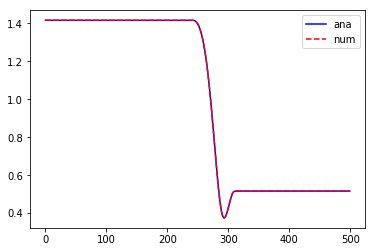

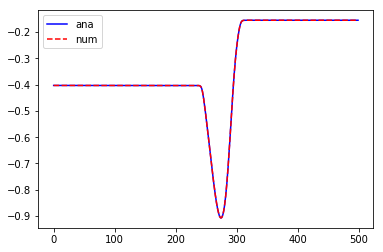

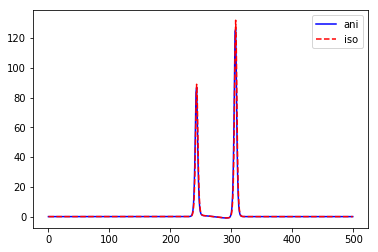

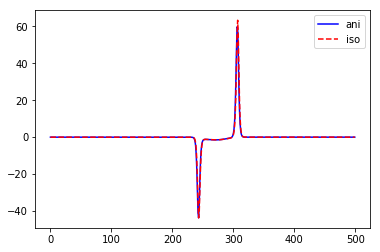

In [174]:
Erfc = erfc(1/np.sqrt(2*(a)))
a_r = np.real(a)
a_i = np.imag(a)
ana = np.pi*np.exp(1/a)*Erfc**2/(2*a)
plt.plot(np.real(ana), 'b', label="ana")
plt.plot(inf_r/np.sqrt(2*np.pi), 'r', label="num", linestyle="dashed")
plt.legend()
plt.show()

plt.plot(np.imag(ana), 'b', label="ana")
plt.plot(inf_i/np.sqrt(2*np.pi), 'r', label="num", linestyle="dashed")
plt.legend()
plt.show()

plt.plot(diag_r/np.sqrt(2*np.pi), 'b', label="ani")
plt.plot(np.real(diag), 'r', label="iso", linestyle="dashed")
plt.legend()
plt.show()
plt.plot(diag_i/np.sqrt(2*np.pi), 'b', label="ani")
plt.plot(np.imag(diag), 'r', label="iso", linestyle="dashed")
plt.legend()
plt.show()

In [11]:
#Poisson Solver
@njit(parallel=True)
def M(r, dr):
    col = np.zeros(3*len(r)-4)
    row = np.zeros(3*len(r)-4)
    data = np.zeros(3*len(r)-4)
    data[0] = 1
    for i in prange(1, len(r)-1):
        row[3*i-1:3*i+2] = i
        col[3*i-1] = i-1
        col[3*i] = i
        col[3*i+1] = i+1
        data[3*i-1] = (r[i]-dr/2)/(dr**2*r[i])
        data[3*i] = -2/dr**2
        data[3*i+1] = (r[i]+dr/2)/(dr**2*r[i])
    row[-1] = len(r)-1
    col[-1] = len(r)-1
    data[-1] = len(r)-1
    return data, col, row

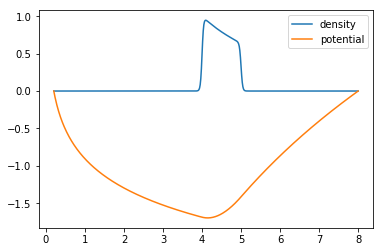

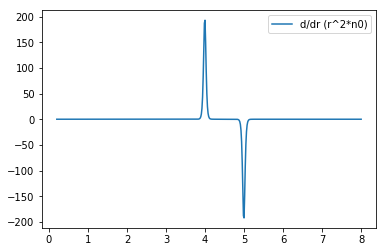

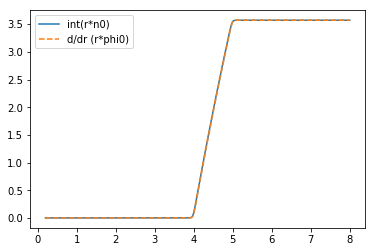

In [82]:
data, col, row = M(r, dr)
A = csc_matrix((data, (row, col)), shape=(len(r), len(r)))
lu = sla.splu(A)

n0 = (8/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
phi = lu.solve(n0)

plt.plot(r, n0, label='density')
plt.plot(r, phi, label='potential')
plt.legend()
plt.show()

dn0 = np.zeros(len(r))
dn0_hot = np.zeros(len(r))
in0 = np.zeros(len(r))
dphi = np.zeros(len(r))

dn0[0] = (r[1]**2*n0[1] - r[0]**2*n0[0])/dr
dn0_hot[0] = (r[1]+r[0])*(n0[1] - n0[0])/(2*dr)
in0[0] = dr*(r[1]*n0[1] + r[0]*n0[0])/2
dphi[0] = (r[0]+dr/2)*(phi[1]-phi[0])/dr
for i in range(len(r)-1):
    dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
    dn0_hot[i] = (r[i+1]+r[i])*(n0[i+1] - n0[i])/(2*dr)
    in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dphi[i] = (r[i]+dr/2)*(phi[i+1]-phi[i])/dr
dn0[-1] = 2*dn0[-2] - dn0[-3]
dn0_hot[-1] = 2*dn0_hot[-2] - dn0_hot[-3]
in0[-1] = 2*in0[-2] - in0[-3]
dphi[-1] = 2*dphi[-2] - dphi[-3]
dphi = dphi - dphi[0]

plt.plot(r, dn0, label='d/dr (r^2*n0)')
plt.legend()
plt.show()

plt.plot(r, in0, label='int(r*n0)')
plt.plot(r, dphi, label='d/dr (r*phi0)', linestyle='dashed')
plt.legend()
plt.show()

#n0_p = (7.9/r**2)*(np.tanh(25*(r-4))-np.tanh(25*(r-5)))
n0_p = np.zeros(len(r))
n0_m = n0-n0_p

dn0_p = np.zeros(len(r))
in0_m = np.zeros(len(r))

dn0_p[0] = (r[1]+r[0])*(n0_p[1] - n0_p[0])/(2*dr)
in0_m[0] = dr*(r[1]*n0_m[1] + r[0]*n0_m[0])/2
for i in range(len(r)-1):
    dn0_p[i] = (r[i+1]+r[i])*(n0_p[i+1] - n0_p[i])/(2*dr)
    in0_m[i] = in0_m[i-1] + dr*(r[i+1]*n0_m[i+1] + r[i]*n0_m[i])/2
dn0_p[-1] = 2*dn0_p[-2] - dn0_p[-3]
in0_m[-1] = 2*in0_m[-2] - in0_m[-3]

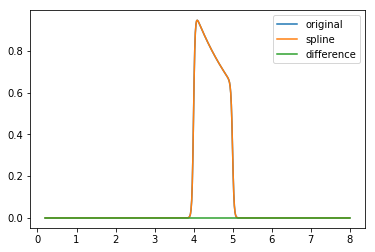

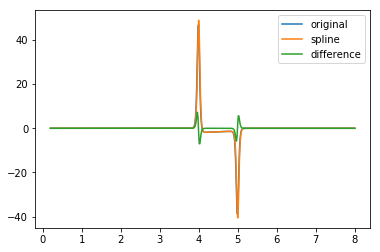

In [13]:
n_spl = Spline(r, n0, k = 5)
dn_spl = n_spl.derivative()
plt.plot(r, n0, label = "original")
plt.plot(r, n_spl(r), label = "spline")
plt.plot(r, n0-n_spl(r), label = "difference")
plt.legend()
plt.show()

plt.plot(r, dn0_hot, label = "original")
plt.plot(r, r*dn_spl(r), label = "spline")
plt.plot(r, dn0_hot-r*dn_spl(r), label = "difference")
plt.legend()
plt.show()

In [14]:
def shooting(r, dr, dn0, in0, omega):
    @njit
    def fun(omega):

        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = ((r[i]-dr/2)/(dr**2*r[i]))
            drm = -2/dr**2
            drr = -((dr**2*r[i])/(r[i]+dr/2))
            diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
            diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [15]:
def hot_shooting(r, dr, n0, dn0, in0, kl, omega):
    @njit
    def fun(omega):

        a = kl/(in0-omega[0]-omega[1]*1j)
        inf_r, inf_i = InF(5, 100, a)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            den = ((in0[i]-omega[0])**2 + omega[1]**2)
            #diag_real = (inf_r[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl) - inf_i[i]*(dn0_hot[i]*omega[1])/den)/np.sqrt(2*np.pi) - n0[i]/kl
            #diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1])/den + inf_i[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl))/np.sqrt(2*np.pi)
            diag = (inf_r[i]+1j*inf_i[i])*(dn0[i]/(omega[0]+1j*omega[1]-in0[i])+n0[i]/kl)/np.sqrt(2*np.pi) - n0[i]/kl
            diag_real = np.real(diag)
            diag_imag = np.imag(diag)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real - 1)*phi_r[i-1] - diag_imag*phi_i[i-1]
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real - 1)*phi_i[i-1] + diag_imag*phi_r[i-1]
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [16]:
def ani_shooting(r, dr, n0, dn0, in0, kl_perp, kl_para, omega):
    @njit
    def fun(omega):

        diag_real, diag_imag = Int_ani(5, 500, in0, dn0_hot, n0, omega, kl_perp, kl_para)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - diag_imag[i]*phi_i[i-1]/np.sqrt(2*np.pi)
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + diag_imag[i]*phi_r[i-1]/np.sqrt(2*np.pi)
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

In [17]:
def mixed_shooting(r, dr, n0_n, n0_p, dn0_n, dn0_p, in0_m, kl_perp, kl_para, omega):
    @njit
    def fun(omega):

        diag_real_n, diag_imag_n = Int_ani(5, 500, in0_m, dn0_n, n0_n, omega, kl_perp, kl_para)
        diag_real_p, diag_imag_p = Int_ani(5, 500, in0_m, dn0_p, n0_p, omega, -kl_perp, -kl_para)
        phi_r = np.zeros(len(r))
        phi_i = np.zeros(len(r))
        phi_r[1] = 1
        phi_i[1] = 1
        for i in range(2, len(r)):
            drl = (r[i]-dr/2)/(dr**2*r[i])
            drm = -2/dr**2
            drr = -(dr**2*r[i])/(r[i]+dr/2)
            phi_r2 = drl*phi_r[i-2]
            phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
            phi_r[i] = drr*(phi_r2 + phi_r1) 

            phi_i2 = drl*phi_i[i-2]
            phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
            phi_i[i] = drr*(phi_i2 + phi_i1)
        return phi_r[-1], phi_i[-1]
    
    Root = root(fun, omega)
    return(Root)

    fjac: array([[-0.76139562,  0.64828752],
       [-0.64828752, -0.76139562]])
     fun: array([-1.54402330e-10, -5.03948596e-11])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.01078214e-07, 2.10820685e-08])
       r: array([-5592.51299939,   376.80893254, -5425.78318699])
  status: 1
 success: True
       x: array([2.00646654, 0.66739401])
[1.00323327 0.33369701]


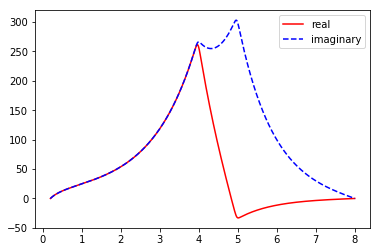

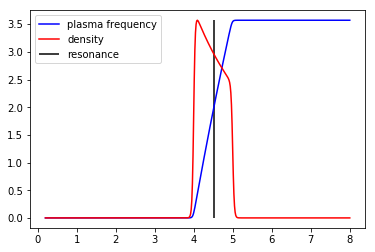

In [ ]:
bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[-0.76139562,  0.64828752],
       [-0.64828752, -0.76139562]])
     fun: array([-1.54402330e-10, -5.03948596e-11])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.01078214e-07, 2.10820685e-08])
       r: array([-5592.51299939,   376.80893254, -5425.78318699])
  status: 1
 success: True
       x: array([2.00646654, 0.66739401])


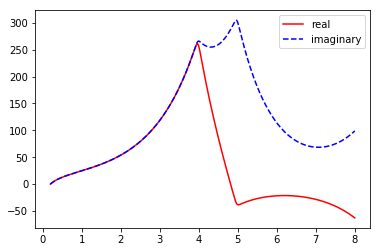

In [ ]:
bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x
kl = 1e-2
a = kl/(in0-omega[0]-omega[1]*1j)
inf_r, inf_i = InF(5, 500, a)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    den = ((in0[i]-omega[0])**2 + omega[1]**2)
    #diag_real = (inf_r[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl) - inf_i[i]*(dn0_hot[i]*omega[1])/den)/np.sqrt(2*np.pi) - n0[i]/kl
    #diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1])/den + inf_i[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl))/np.sqrt(2*np.pi)
    diag = (inf_r[i]+1j*inf_i[i])*(dn0_hot[i]/(omega[0]+1j*omega[1]-in0[i])+n0[i]/kl)/np.sqrt(2*np.pi) - n0[i]/kl
    diag_real = np.real(diag)
    diag_imag = np.imag(diag)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] - diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] + diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)
    
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

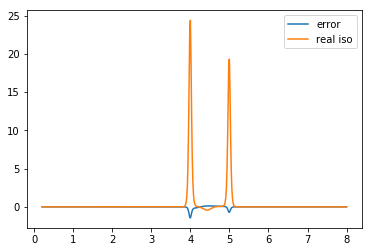

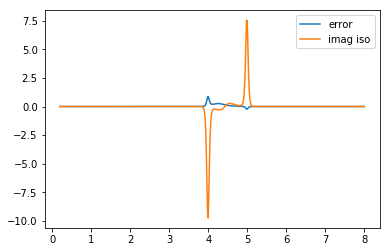

In [ ]:
omega = bullet.x
kl = 1e-1
int_ani_r, int_ani_i = Int_ani(5, 500, in0, dn0_hot, n0, omega, kl, kl)
a = kl/(in0-omega[0]-omega[1]*1j)
inf_r, inf_i = InF(5, 500, a)
diag = (inf_r+1j*inf_i)*(dn0_hot/(omega[0]+1j*omega[1]-in0)+n0/kl)/np.sqrt(2*np.pi) - n0/kl
diag_real = np.real(diag)
diag_imag = np.imag(diag)
plt.plot(r, (diag_real-int_ani_r/np.sqrt(2*np.pi)), label='error')
plt.plot(r, diag_real, label='real iso')
#plt.plot(r, int_ani_r/np.sqrt(2*np.pi), label='real ani', linestyle="dashed")
plt.legend()
plt.show()
plt.plot(r, (diag_imag-int_ani_i/np.sqrt(2*np.pi)), label='error')
plt.plot(r, diag_imag, label='imag iso')
#plt.plot(r, int_ani_i/np.sqrt(2*np.pi), label='imag ani', linestyle="dashed")
plt.legend()
plt.show()

    fjac: array([[-0.75784137,  0.65243886],
       [-0.65243886, -0.75784137]])
     fun: array([ 4.90026477e-11, -1.29272501e-10])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([ 1.66976290e-06, -1.14319537e-06])
       r: array([-5451.43773301,   -39.43713958, -5349.34670903])
  status: 1
 success: True
       x: array([2.03353705, 0.69419408])
[1.01676852 0.34709704]


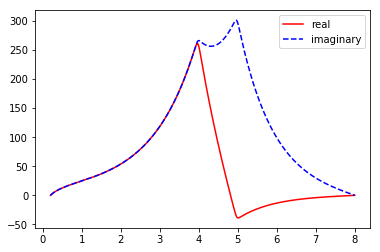

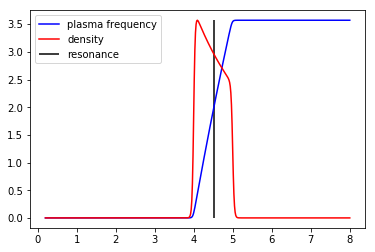

In [20]:
kl = 1e-2

bullet = hot_shooting(r, dr, n0, dn0_hot, in0, kl, np.array([2.0, 0.6]))
print(bullet)
omega = bullet.x

a = kl/(-omega[0]-omega[1]*1j+in0)
inf_r, inf_i = InF(5, 100, a)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    den = ((in0[i]-omega[0])**2 + omega[1]**2)
    #diag_real = (inf_r[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl) - inf_i[i]*(dn0_hot[i]*omega[1])/den)/np.sqrt(2*np.pi) - n0[i]/kl
    #diag_imag = (inf_r[i]*(dn0_hot[i]*omega[1])/den + inf_i[i]*(dn0_hot[i]*(in0[i]-omega[0])/den+n0[i]/kl))/np.sqrt(2*np.pi)
    diag = (inf_r[i]+1j*inf_i[i])*(dn0_hot[i]/(omega[0]+1j*omega[1]-in0[i])+n0[i]/kl)/np.sqrt(2*np.pi) - n0[i]/kl
    diag_real = np.real(diag)
    diag_imag = np.imag(diag)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] - diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] + diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

    fjac: array([[-0.56832493,  0.82280422],
       [-0.82280422, -0.56832493]])
     fun: array([-8.07490388e-12, -2.36690823e-09])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([ 1.52350821e-05, -1.30970924e-05])
       r: array([-9526.70934519,   -15.90015449, -9445.71390925])
  status: 1
 success: True
       x: array([3.00501369, 0.1290718 ])
[1.50250684 0.0645359 ]


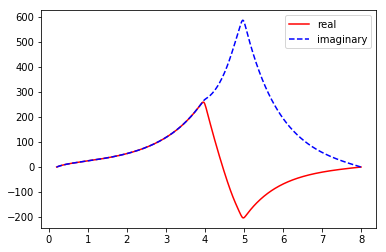

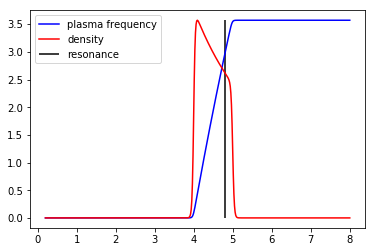

In [ ]:
kl_perp = 1
kl_para = 5e-1

bullet = ani_shooting(r, dr, n0, dn0_hot, in0, kl_perp, kl_para, np.array([2.0, 0.6]))
print(bullet)
omega = bullet.x

diag_real, diag_imag = Int_ani(5, 500, in0, dn0_hot, n0, omega, kl_perp, kl_para)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - diag_imag[i]*phi_i[i-1]/np.sqrt(2*np.pi)
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real[i]/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + diag_imag[i]*phi_r[i-1]/np.sqrt(2*np.pi)
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

In [ ]:
kl_perp = 1
kl_para = 5e-1

bullet = mixed_shooting(r, dr, n0, n0_p, dn0_hot, dn0_p, in0_m, kl_perp, kl_para, np.array([1.0, 1.0]))
print(bullet)
omega = bullet.x
diag_real_n, diag_imag_n = Int_ani(5, 500, in0_m, dn0_hot, n0, omega, kl_perp, kl_para)
diag_real_p, diag_imag_p = Int_ani(5, 500, in0_m, dn0_p, n0_p, omega, -kl_perp, -kl_para)
phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = (r[i]-dr/2)/(dr**2*r[i])
    drm = -2/dr**2
    drr = -(dr**2*r[i])/(r[i]+dr/2)
    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_r[i-1] - (diag_imag_n[i]-diag_imag_p[i])*phi_i[i-1]/np.sqrt(2*np.pi)
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + (diag_real_n[i]-diag_real_p[i])/np.sqrt(2*np.pi) - 1)*phi_i[i-1] + (diag_imag_n[i]-diag_imag_p[i])*phi_r[i-1]/np.sqrt(2*np.pi)
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x7f7e2e2a0b70>.
Failed in nopython mode pipeline (step: analyzing bytecode)
The compiler failed to analyze the bytecode. Variable 'f0' is not defined.

File "<ipython-input-8-ffdcccd6a66a>", line 26:
def Int_ani(v_max, lr, in0, dn0, n0, omega, kl_perp, kl_para):
    <source elided>
            f = exp/den*(dn0[i] + n0[i]*bra)
            inf_dperp0 = inf_dperp0 + dperp*(f+f0)/2
            ^

During: resolving callee type: type(CPUDispatcher(<function Int_ani at 0x7f7e2eff6b70>))
During: typing of call at <ipython-input-18-2cfbf35f31e3> (5)

Enable logging at debug level for details.

File "<ipython-input-18-2cfbf35f31e3>", line 5:
    def fun(omega):
        <source elided>

        diag_real_n, diag_imag_n = Int_ani(5, 500, in0_m, dn0_n, n0_n, omega, kl_perp, kl_para)
        ^


In [ ]:
stop

NameError: name 'stop' is not defined

In [ ]:
for i in range(i_x):    
    for j in range(i+1, i+i_y):
            
            bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
            omega = bullet.x
            G11 = green[i, i]
            G22 = green[j, j]
            G12 = green[i, j]
            n0_norm = 1/np.log(r[j]/r[i])
            p = (G11 - G22 - np.log(r[j]/r[i]))/2
            q = (G12**2 - G11*G22 - np.log(r[j]/r[i])*G11)/4

            if (p/2)**2 > q:
                omega_p[i, j-i] = n0_norm*(-p/2 + np.sqrt((p/2)**2 - q))
                omega_m[i, j-i] = n0_norm*(-p/2 - np.sqrt((p/2)**2 - q))
            else:
                omega_p[i, j-i] = n0_norm*(-p/2 + 1j*np.sqrt(-(p/2)**2 + q))
                omega_m[i, j-i] = n0_norm*(-p/2 - 1j*np.sqrt(-(p/2)**2 + q))
    return omega_p, omega_m

NameError: name 'stop' is not defined

In [ ]:
@njit(parallel=True)
def density_stuff(r, dr, n0):
    dn0 = np.zeros(len(r))
    in0 = np.zeros(len(r))

    for i in range(len(r)-1):
        dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
        in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dn0[-1] = 2*dn0[-2] - dn0[-3]
    in0[-1] = 2*in0[-2] - in0[-3]
    return dn0, in0

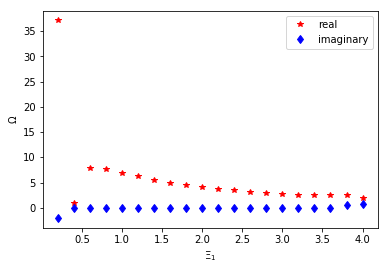

In [ ]:

r1 = np.linspace(0.2, 4, 20)
omega_r = np.empty(len(r1))
omega_i = np.empty(len(r1))
for i in range(len(r1)):
    n0 = (8/r**2)*(np.tanh(25*(r-r1[i]))-np.tanh(25*(r-5)))
    dn0, in0 = density_stuff(r, dr, n0)

    bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.1]))
    omega_r[i] = bullet.x[0]
    omega_i[i] = bullet.x[1]

plt.plot(r1, omega_r, "r*", label='real')
plt.plot(r1, omega_i, "bd", label='imaginary')
plt.ylabel("$\Omega$")
plt.xlabel("$\Xi_1$")
plt.legend()
plt.show()

    fjac: array([[-0.70725196,  0.70696157],
       [-0.70696157, -0.70725196]])
     fun: array([10423.2871614, 10423.2811531])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 16
     qtf: array([-3.03517254e+00, -1.47407516e+04])
       r: array([ 2.73686449e-03, -1.35039151e-03,  1.42014222e-06])
  status: 5
 success: False
       x: array([ 6027.81578375, 12066.53225831])
[3013.90789188 6033.26612916]


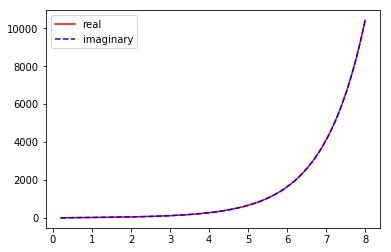

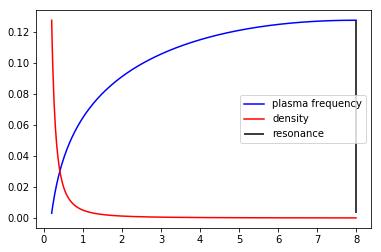

In [ ]:
#n0 = (8/r**2)*(np.tanh(25*(r-0.2))-np.tanh(25*(r-5)))
n0 = (r**-2 - R2**-2)/R1**-2
dn0, in0 = density_stuff(r, dr, n0)

bullet = shooting(r, dr, dn0, in0, np.array([1.0, 0.3]))
print(bullet)
omega = bullet.x

phi_r = np.zeros(len(r))
phi_i = np.zeros(len(r))
phi_r[1] = 1
phi_i[1] = 1
for i in range(2, len(r)):
    drl = ((r[i]-dr/2)/(dr**2*r[i]))
    drm = -2/dr**2
    drr = -((dr**2*r[i])/(r[i]+dr/2))
    diag_real = (dn0[i]*(omega[0]-in0[i]))/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))
    diag_imag = (dn0[i]*omega[1])/(r[i]*((omega[0]-in0[i])**2 + omega[1]**2))

    phi_r2 = drl*phi_r[i-2]
    phi_r1 = (drm + diag_real - 1)*phi_r[i-1] + diag_imag*phi_i[i-1]
    phi_r[i] = drr*(phi_r2 + phi_r1) 

    phi_i2 = drl*phi_i[i-2]
    phi_i1 = (drm + diag_real - 1)*phi_i[i-1] - diag_imag*phi_r[i-1]
    phi_i[i] = drr*(phi_i2 + phi_i1)

print(omega/2)
plt.plot(r, phi_r, "r", label='real')
plt.plot(r, phi_i, "b", label='imaginary', linestyle='dashed')
plt.legend()
plt.show()

i_res = np.argmin(abs(in0-omega[0]))

plt.plot(r, in0, "b", label='plasma frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='density')
plt.vlines(r[i_res], np.min(in0), np.max(in0), "k", label='resonance')
plt.legend()
plt.show()

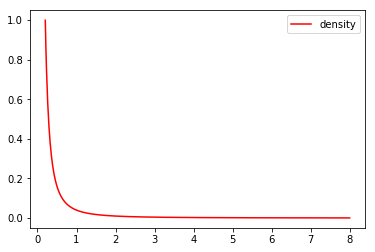

0.0


In [ ]:
n0 = (r**-2 - R2**-2)/R1**-2

plt.plot(r, n0, "r", label='density')
plt.legend()
plt.show()
print(n0[-1])